In [102]:
BATCH_SIZE = 32
MAX_LEN = 716
EMBEDDING_DIM = 300

In [103]:
import tensorflow as tf

def parse(example):
    features = tf.parse_single_example(
        example,
        features={
            'X': tf.FixedLenFeature([MAX_LEN], dtype=tf.float32),
            'Y': tf.FixedLenFeature((9,), dtype=tf.float32)
        })
    
    X = features['X']
    Y = features['Y']
    
    return X, Y

In [104]:
def iterator(tfrecord_path, data_len):
    dataset = tf.data.TFRecordDataset([tfrecord_path]).map(parse)
    dataset = dataset.repeat(-1).batch(data_len)
    iterator = dataset.make_one_shot_iterator()

    X, Y = iterator.get_next()
    X = tf.reshape(X, [-1, MAX_LEN])
    
    return X, Y

In [105]:
%%time

x_train, y_train = iterator('train_with_sp.tfrecord', 5893)
x_test, y_test = iterator('test_with_sp.tfrecord', 1474)

x_train = tf.Session().run(x_train)
y_train = tf.Session().run(y_train)
x_test = tf.Session().run(x_test)
y_test = tf.Session().run(y_test)

CPU times: user 9.29 s, sys: 417 ms, total: 9.7 s
Wall time: 8.63 s


In [106]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5893, 716), (5893, 9), (1474, 716), (1474, 9))

In [107]:
filters = 256
kernel_size = 3
hidden_dims = 256
epochs = 10

In [108]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Conv1D, GlobalMaxPooling1D

model = Sequential()
model.add(Embedding(8001, EMBEDDING_DIM, input_length=MAX_LEN))
model.add(Conv1D(filters,
                kernel_size,
                padding='valid',
                activation='relu',
                strides=1,))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, 
                activation='relu'
               ))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 716, 300)          2400300   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 714, 256)          230656    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 9)                 2313      
Total params: 2,699,061
Trainable params: 2,699,061
Non-trainable params: 0
_________________________________________________________________


In [109]:
from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

In [110]:
%%time

hist = model.fit(x_train,
                 y_train,
                batch_size=BATCH_SIZE,
                epochs=epochs,
                validation_data=(x_test, y_test))

Train on 5893 samples, validate on 1474 samples
Epoch 1/10
5893/5893 [==============================] - 3s 493us/step - loss: 0.9979 - acc: 0.6776 - val_loss: 0.2990 - val_acc: 0.9037
Epoch 2/10
5893/5893 [==============================] - 2s 261us/step - loss: 0.2051 - acc: 0.9389 - val_loss: 0.1769 - val_acc: 0.9471
Epoch 3/10
5893/5893 [==============================] - 2s 262us/step - loss: 0.0907 - acc: 0.9751 - val_loss: 0.1778 - val_acc: 0.9457
Epoch 4/10
5893/5893 [==============================] - 2s 263us/step - loss: 0.0385 - acc: 0.9913 - val_loss: 0.1603 - val_acc: 0.9539
Epoch 5/10
5893/5893 [==============================] - 2s 260us/step - loss: 0.0180 - acc: 0.9963 - val_loss: 0.1557 - val_acc: 0.9545
Epoch 6/10
5893/5893 [==============================] - 2s 261us/step - loss: 0.0125 - acc: 0.9973 - val_loss: 0.1544 - val_acc: 0.9600
Epoch 7/10
5893/5893 [==============================] - 2s 263us/step - loss: 0.0056 - acc: 0.9993 - val_loss: 0.1532 - val_acc: 0.9613


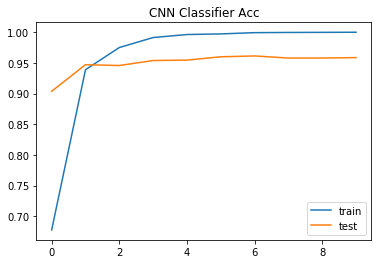

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('CNN Classifier Acc')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

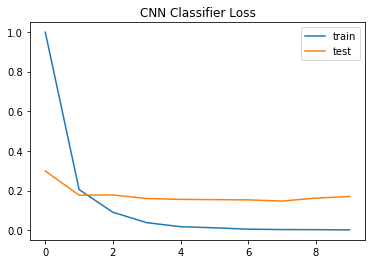

In [114]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('CNN Classifier Loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [115]:
import numpy as np

pred_values_orig = model.predict(x_test)
pred_values = np.argmax(pred_values_orig, axis=1)
print('shape of pred_values:', pred_values.shape)
y_test = np.argmax(y_test, axis=1)
print('shape of y_test:', y_test.shape)

shape of pred_values: (1474,)
shape of y_test: (1474,)


In [116]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['dokujo-tsushin', 'it-life-hack', 'kaden-channel',\
                'livedoor-homme', 'movie-enter', 'peachy', 'smax',\
                'sports-watch', 'topic-news']

result = classification_report(y_test, pred_values, digits=3, target_names=target_names)

print(result)

                precision    recall  f1-score   support

dokujo-tsushin      0.959     0.943     0.951       175
  it-life-hack      0.927     0.994     0.959       154
 kaden-channel      0.965     0.982     0.973       167
livedoor-homme      0.958     0.798     0.871       114
   movie-enter      0.961     0.989     0.975       174
        peachy      0.921     0.951     0.936       184
          smax      0.984     0.968     0.976       186
  sports-watch      0.981     0.975     0.978       163
    topic-news      0.975     0.981     0.978       157

     micro avg      0.959     0.959     0.959      1474
     macro avg      0.959     0.953     0.955      1474
  weighted avg      0.959     0.959     0.958      1474



Normalized confusion matrix
[[0.943 0.    0.006 0.011 0.006 0.029 0.    0.006 0.   ]
 [0.    0.994 0.    0.    0.    0.    0.006 0.    0.   ]
 [0.    0.006 0.982 0.    0.    0.006 0.006 0.    0.   ]
 [0.018 0.07  0.009 0.798 0.044 0.053 0.    0.009 0.   ]
 [0.    0.    0.    0.    0.989 0.011 0.    0.    0.   ]
 [0.027 0.    0.    0.011 0.005 0.951 0.    0.005 0.   ]
 [0.    0.011 0.016 0.    0.    0.005 0.968 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.975 0.025]
 [0.    0.006 0.006 0.    0.    0.    0.006 0.    0.981]]


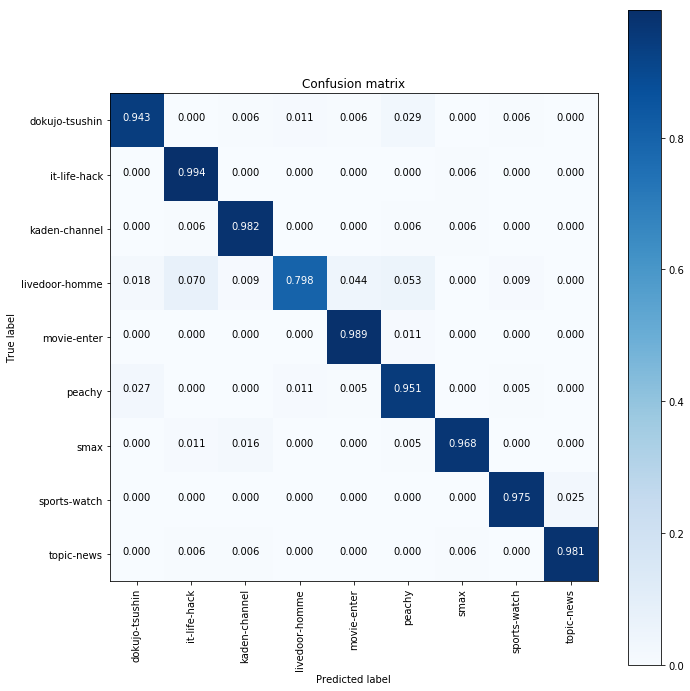

In [117]:
from plot_graph import plot_confusion_matrix
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 10,10

conf_mat = confusion_matrix(y_test, pred_values)
plot_confusion_matrix(conf_mat, target_names, normalize=True)